#Imports

In [2]:
%tensorflow_version 2.x

import tensorflow as tf
import tensorflow_hub as hub

from tensorflow.keras import Sequential
from tensorflow.keras.utils import get_file
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import shutil
import numpy as np
import PIL.Image as Image
import matplotlib.pylab as plt

#dark mode
plt.rc_context({'xtick.color':'w', 'ytick.color':'w', 'text.color':'w', 'axes.labelcolor':'w'})

seed=1234
np.random.seed(seed)
tf.random.set_seed(seed)

TensorFlow 2.x selected.


In [3]:
!pip install googleimagedownloader
from googleimagedownloader.googleimagedownloader import GoogleImageDownloader

In [0]:
IMAGE_SIZE = (224, 224)

In [0]:
feature_extractor_url ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4" 

81920/79482 [==============================] - 0s 2us/step


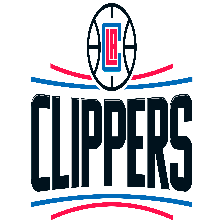

In [7]:
test_image = get_file('img.png','https://worldsportlogos.com/wp-content/uploads/2019/06/Los-Angeles-Clippers-Logo.png')
test_image = Image.open(test_image).resize(IMAGE_SIZE)
test_image

In [8]:
test_image = np.array(test_image)/255.0
test_image.shape

(224, 224)

#Transfer Learning

#Build the dataset

In [0]:
class_names = ['kobe bryant','Lebron James']
path = 'dataset/'

train_dir = os.path.join(path, 'train')
validation_dir = os.path.join(path, 'validation')

train_ca_dir = os.path.join(train_dir, 'kobe_bryant')  
train_im_dir = os.path.join(train_dir, 'lebron_james')  
validation_ca_dir = os.path.join(validation_dir, 'kobe_bryant') 
validation_im_dir = os.path.join(validation_dir, 'lebron_james')  

if os.path.exists(path):
  shutil.rmtree(path)

os.makedirs(train_ca_dir)
os.makedirs(train_im_dir)
os.makedirs(validation_ca_dir)    
os.makedirs(validation_im_dir)

In [0]:
def manage_images(src, dest_train, dest_val, image_resize=IMAGE_SIZE, val_split=0.1, prefix=''):
  total = len(os.listdir(src))
  val = np.int(total*val_split)
  count = 0
  files = os.listdir(src)

  for file_name in files:
    try:
      dest = dest_train if count >= val else dest_val
      dest_file = os.path.join(dest, prefix + file_name) 

      img = Image.open(os.path.join(src,file_name))
      img.verify()
      # reopen because verify() was called
      # If you need to load the image after using this method, you must reopen the image file.
      # https://pillow.readthedocs.io/en/3.1.x/reference/Image.html
      img = Image.open(os.path.join(src,file_name))
      #resize
      img = img.resize(image_resize, Image.ANTIALIAS)
      #move
      img.save(dest_file)  
      count+=1 
    except Exception as e:
        print('Invalid image: ',file_name,e)
        if os.path.exists(dest_file):
          os.remove(dest_file)
  return

In [0]:
img_dir = os.path.realpath('Images/')

In [13]:
queries = ['lakers' ]
pos = 0
for query in queries:
  image = GoogleImageDownloader(Query='kobe bryant'+query, numberImage=100)
  try:
    image.downloadImages()
  except Exception as e:
    print('Error ',e)
  #verify, resize, move and split sets
  manage_images(img_dir, train_ca_dir, validation_ca_dir,prefix=str(pos)+'-')
  pos+=1

https://www.google.co.in/search?q=kobe bryantlakers&source=lnms&tbm=isch
Total Time : 0:00:10.689212
Invalid image:  74.jpg cannot identify image file '/content/Images/74.jpg'
Invalid image:  19.jpg cannot identify image file '/content/Images/19.jpg'
Invalid image:  18.jpg cannot identify image file '/content/Images/18.jpg'
Invalid image:  48.jpg cannot identify image file '/content/Images/48.jpg'
Invalid image:  15.jpg cannot identify image file '/content/Images/15.jpg'


In [14]:
queries = ['cavaliers']
pos = 0
for query in queries:
  image = GoogleImageDownloader(Query='lebron james'+query, numberImage=100)
  try:
    image.downloadImages()
  except Exception as e:
    print('Error ',e)
  #verify, resize, move and split sets
  manage_images(img_dir, train_im_dir, validation_im_dir,prefix=str(pos)+'-')
  pos+=1

https://www.google.co.in/search?q=lebron jamescavaliers&source=lnms&tbm=isch
Total Time : 0:00:08.687114
Invalid image:  88.jpg cannot identify image file '/content/Images/88.jpg'
Invalid image:  52.jpg cannot identify image file '/content/Images/52.jpg'
Invalid image:  25.jpg cannot identify image file '/content/Images/25.jpg'
Invalid image:  57.jpg cannot identify image file '/content/Images/57.jpg'
Invalid image:  83.jpg cannot identify image file '/content/Images/83.jpg'


In [15]:
total_train = len(os.listdir(train_ca_dir))+ len(os.listdir(train_im_dir))
total_val = len(os.listdir(validation_ca_dir))+ len(os.listdir(validation_im_dir))

print('total training Kobe Bryant images:', len(os.listdir(train_ca_dir)))
print('total training Lebron James images:', len(os.listdir(train_im_dir)))

print('total validation Kobe Bryant images:', len(os.listdir(validation_ca_dir)))
print('total validation Lebron James images:', len(os.listdir(validation_im_dir)))
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)

total training Kobe Bryant images: 85
total training Luka Doncic images: 85
total validation Kobe Bryant images: 10
total validation Luka Doncic images: 10
--
Total training images: 170
Total validation images: 20


In [0]:
train_image_generator = ImageDataGenerator(rescale=1./255)
validation_image_generator = ImageDataGenerator(rescale=1./255)

In [17]:
train_data_gen = train_image_generator.flow_from_directory(train_dir,
                                                           shuffle=True,
                                                           batch_size=32,
                                                           target_size=IMAGE_SIZE,
                                                           class_mode='binary')

Found 170 images belonging to 2 classes.


In [18]:
val_data_gen = validation_image_generator.flow_from_directory(validation_dir,
                                                              target_size=IMAGE_SIZE,
                                                              class_mode='binary')

Found 20 images belonging to 2 classes.


In [0]:
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                         input_shape=IMAGE_SIZE+(3,))

In [0]:
image_batch, labels_batch = next(train_data_gen)

In [22]:
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

(32, 1280)


In [0]:
feature_extractor_layer.trainable = False

In [24]:
model = Sequential([
  feature_extractor_layer,
  Dense(1024, activation='relu'),
  Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 1024)              1311744   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1025      
Total params: 3,570,753
Trainable params: 1,312,769
Non-trainable params: 2,257,984
_________________________________________________________________


In [0]:
def plot_images(img_batch, labels, predicted_labels):
  plt.figure(figsize=(12,12))
  plt.subplots_adjust(hspace=0.5)
  for i in range(15):
    plt.subplot(6,5,i+1) 
    plt.imshow(img_batch[i])
    color = "green" if predicted_labels[i] == class_names[np.int(labels[i])] else "red"
    plt.title(predicted_labels[i], color=color)
    plt.axis('off')

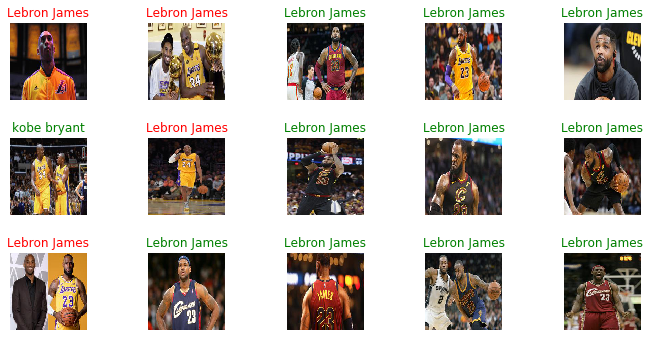

In [27]:
predictions = model(image_batch)
predicted_class_names = np.array(class_names)[np.rint(predictions).astype('int32')].flatten()
plot_images(image_batch, labels_batch, predicted_class_names)

In [0]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [29]:
history = model.fit(
    train_data_gen,
    epochs=5,
    steps_per_epoch=5,
    validation_data=val_data_gen
)

  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


Train for 5 steps, validate for 1 steps
Epoch 1/5
5/5 [==============================] - 9s 2s/step - loss: 1.3882 - accuracy: 0.5072 - val_loss: 1.1189 - val_accuracy: 0.5000
Epoch 2/5
5/5 [==============================] - 5s 1s/step - loss: 0.5495 - accuracy: 0.7174 - val_loss: 0.5323 - val_accuracy: 0.7000
Epoch 3/5
5/5 [==============================] - 5s 1s/step - loss: 0.3755 - accuracy: 0.7899 - val_loss: 0.5984 - val_accuracy: 0.6500
Epoch 4/5
5/5 [==============================] - 5s 1s/step - loss: 0.2832 - accuracy: 0.8841 - val_loss: 0.3235 - val_accuracy: 0.8000
Epoch 5/5
5/5 [==============================] - 5s 1s/step - loss: 0.1970 - accuracy: 0.8986 - val_loss: 0.2713 - val_accuracy: 0.8000


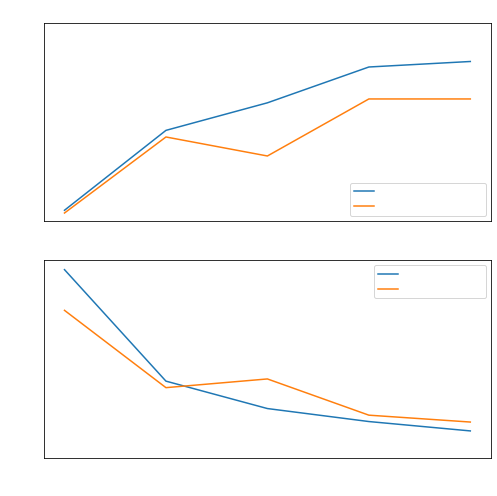

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.5])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

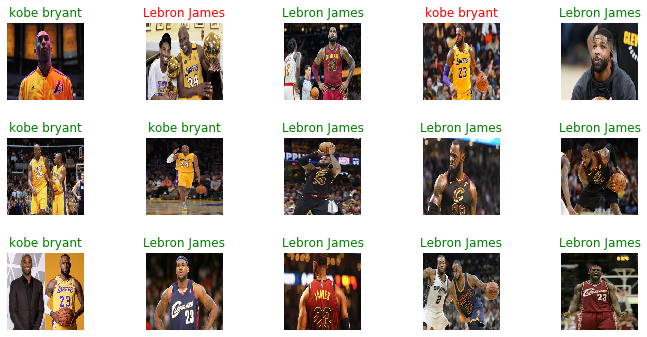

In [32]:
predictions = model(image_batch)
predicted_class_names = np.array(class_names)[np.rint(predictions).astype('int32')].flatten()

plot_images(image_batch, labels_batch, predicted_class_names)